In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import pygsheets
import pickle as pkl
import pandas as pd
import load_data
import sys
sys.path.append('modeling')
import exponential_modeling

outcomes = ['tot_cases', 'tot_deaths']
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
outcome_cases = [k for k in df_county.keys() if '#Cases' in k][-1]
df_county = df_county.sort_values(outcome_cases, ascending=False)
NUM_DAYS_LIST = [1, 3, 5]
# df_county = exponential_modeling.estimate_deaths(df_county) # adds key 
for num_days_in_future in NUM_DAYS_LIST: # 1 is tomorrow
    df_county = exponential_modeling.estimate_cases(df_county, 
                                                     method='exponential',
                                                     target_day=[num_days_in_future],
                                                     output_key=f'Predicted Deaths {num_days_in_future}-day') # adds key 
df = df_hospital.merge(df_county, how='left', on='countyFIPS')
df[outcomes] = df[outcomes].fillna(0)

# note this many hospitals couldn't be matched to a county - we don't know how to include them!
print('# unmatched hospitals:', df['countyFIPS'].isna().sum())
print('# matched hospitals:', (~df['countyFIPS'].isna()).sum())
print('# academic matched hospitals:', (~df['countyFIPS'].isna() & df['IsAcademicHospital']).sum())
print('# academic matched hospitals w/ ICU beds:', (~df['countyFIPS'].isna() & 
                                                    df['IsAcademicHospital'] &
                                                    df['ICU Beds'] > 0).sum())

# unmatched hospitals: 598
# matched hospitals: 6545
# academic matched hospitals: 1215
# academic matched hospitals w/ ICU beds: 1087


- we filter by academic hospitals since they seem to have enough personnel to deal with extra ventilators
- we also filter to only include hospitals w/ ICU beds
- unfortunately we don't look into FQHCs, as they may not be the place to receive urgent ventilator care
- might want to up-weight larger hospitals, as they might have more capacity
- 10-20% ventilators will be used for other stuff
- use income information?

In [2]:
# rename keys
remap = {
    '#ICU_beds': 'ICU Beds in County', 
    'Total Employees': 'Hospital Employees',
    'County Name_x': 'County Name',
    'Facility Name_x': 'Facility Name',
    'tot_deaths': 'Tot Deaths',
    'tot_cases': 'Tot Cases',
}
df = df.rename(columns=remap)

# aggregate employees by county
total_emp_county = df.groupby('countyFIPS').agg({'Hospital Employees': 'sum'})
total_emp_county = total_emp_county.rename(columns={'Hospital Employees': 'Hospital Employees in County'})
df_county = pd.merge(df_county, total_emp_county, how='left', on='countyFIPS')
df = pd.merge(df, total_emp_county, how='left', on='countyFIPS')

# filter hospitals
df = df[~df['countyFIPS'].isna() & df['IsAcademicHospital'] & df['Hospital Employees'] > 0]
df = df.sort_values(by=['Tot Cases', 'Hospital Employees'], ascending=False)

# fraction of employees out of all county hospitals
df['Frac Hospital Employees of County'] = df['Hospital Employees'] / df['Hospital Employees in County']

# get predicted #cases
for n in NUM_DAYS_LIST:
    df[f'Mask Demand {n}-day'] = (df['Tot Cases'] * 5 * df['Frac Hospital Employees of County']).fillna(0)
    df[f'Mask Supply {n}-day'] = df['Hospital Employees'].fillna(0)
    df[f'Mask Needed {n}-day'] = df[f'Mask Demand {n}-day'] - df[f'Mask Supply {n}-day']
    df[f'Mask Needed {n}-day'] = df[f'Mask Needed {n}-day'].apply(lambda x: max(0, x)).astype(int)
df['Num Shipped'] = 0

In [3]:
# make smaller df
outcome_keys = ['Tot Cases', 'Tot Deaths']
mask_keys = []
for n in NUM_DAYS_LIST:
    for k in ['Mask Needed', 'Mask Demand', 'Mask Supply']:
        mask_keys.append(k + f' {n}-day')

county_info_keys = ['County Name']
county_meta_keys = ['Hospital Employees in County', 'City']
hospital_keys = ['Facility Name']
hospital_contact_keys = ['Website',  'Phone Number']
hospital_meta_keys = ['ICU Beds', 'Total Beds', 'Hospital Employees', 'Hospital Type',
                      'Frac Hospital Employees of County', 'Mortality national comparison',
                      'Urban or Rural Designation']

# d contains all these keys
d = df[outcome_keys + mask_keys + county_info_keys + county_meta_keys + \
       hospital_keys + hospital_contact_keys + hospital_meta_keys + \
       ['Num Shipped', 'CMS Certification Number', 'countyFIPS']].round(2)

# things to output
d_mask = d[mask_keys + hospital_keys + county_info_keys + ['CMS Certification Number', 'countyFIPS'] ]
contact_df_keys = hospital_keys + county_info_keys + ['City'] + hospital_contact_keys + ['CMS Certification Number', 'countyFIPS'] 
d_contact = d[contact_df_keys]
d_shipped = df[['Num Shipped'] + hospital_keys + county_info_keys + ['CMS Certification Number', 'countyFIPS']]
d_full = d.drop(hospital_contact_keys, axis='columns')

In [4]:
# contact info per county
remap2 = {
    'tot_cases': 'Tot Cases'
}
df_county_keys = ['CountyName', 'countyFIPS', 'Tot Cases']
df_county = df_county.rename(columns=remap2)
df_c = df_county[df_county_keys]

**look at most affected hospitals**

In [5]:
# d.groupby('countyFIPS').head(1).head(8) # look at top counties

# export to google sheets

- requires a creds.json file in the root directory
- need to make a sheet and share it with `chandan@r4l-predictions.iam.gserviceaccount.com`
- full hospitals spreadsheet: https://docs.google.com/spreadsheets/d/1bEtoXmlWDKLLDwUdjOC_Jx1aIqYGAbP_7oBtIXDLxWg/edit#gid=0

In [11]:
gc = pygsheets.authorize(service_file='creds.json')

#open the google spreadsheet (where 'PY to Gsheet Test' is the name of my sheet)
sheet_name = 'Mask Demand Prediction'
sh = gc.open(sheet_name) # name of the hospital

# masks
wks = sh[0] #select a sheet
wks.update_value('A1', "Note: this sheet is read-only (automatically generated by the data and model)")
wks.set_dataframe(d_mask, (3, 1)) #update the first sheet with df, starting at cell B2. 

# full metadata
wks = sh[1]
wks.update_value('A1', "Note: this sheet is read-only (automatically generated by the data and model)")
wks.set_dataframe(d_full, (3, 1))

# full metadata
wks = sh[2]
wks.update_value('A1', "Note: this sheet keeps track of number of shipped ventilators)")
wks.set_dataframe(d_shipped, (3, 1))

HttpError: <HttpError 400 when requesting https://sheets.googleapis.com/v4/spreadsheets/1bEtoXmlWDKLLDwUdjOC_Jx1aIqYGAbP_7oBtIXDLxWg/values/Hosp%20Recs%21A1%3AA1?valueInputOption=USER_ENTERED&alt=json returned "You are trying to edit a protected cell or object. Please contact the spreadsheet owner to remove protection if you need to edit.">

In [24]:
# these should not be updated all the time
wks = sh[3]
wks.update_value('A1', "Hospital-level contact information")
wks.update_value('A2', "Columns A-G are read-only")
wks.set_dataframe(d_contact, (5, 1))

# useful county-level plots

/Users/Tiffany/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/Tiffany/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


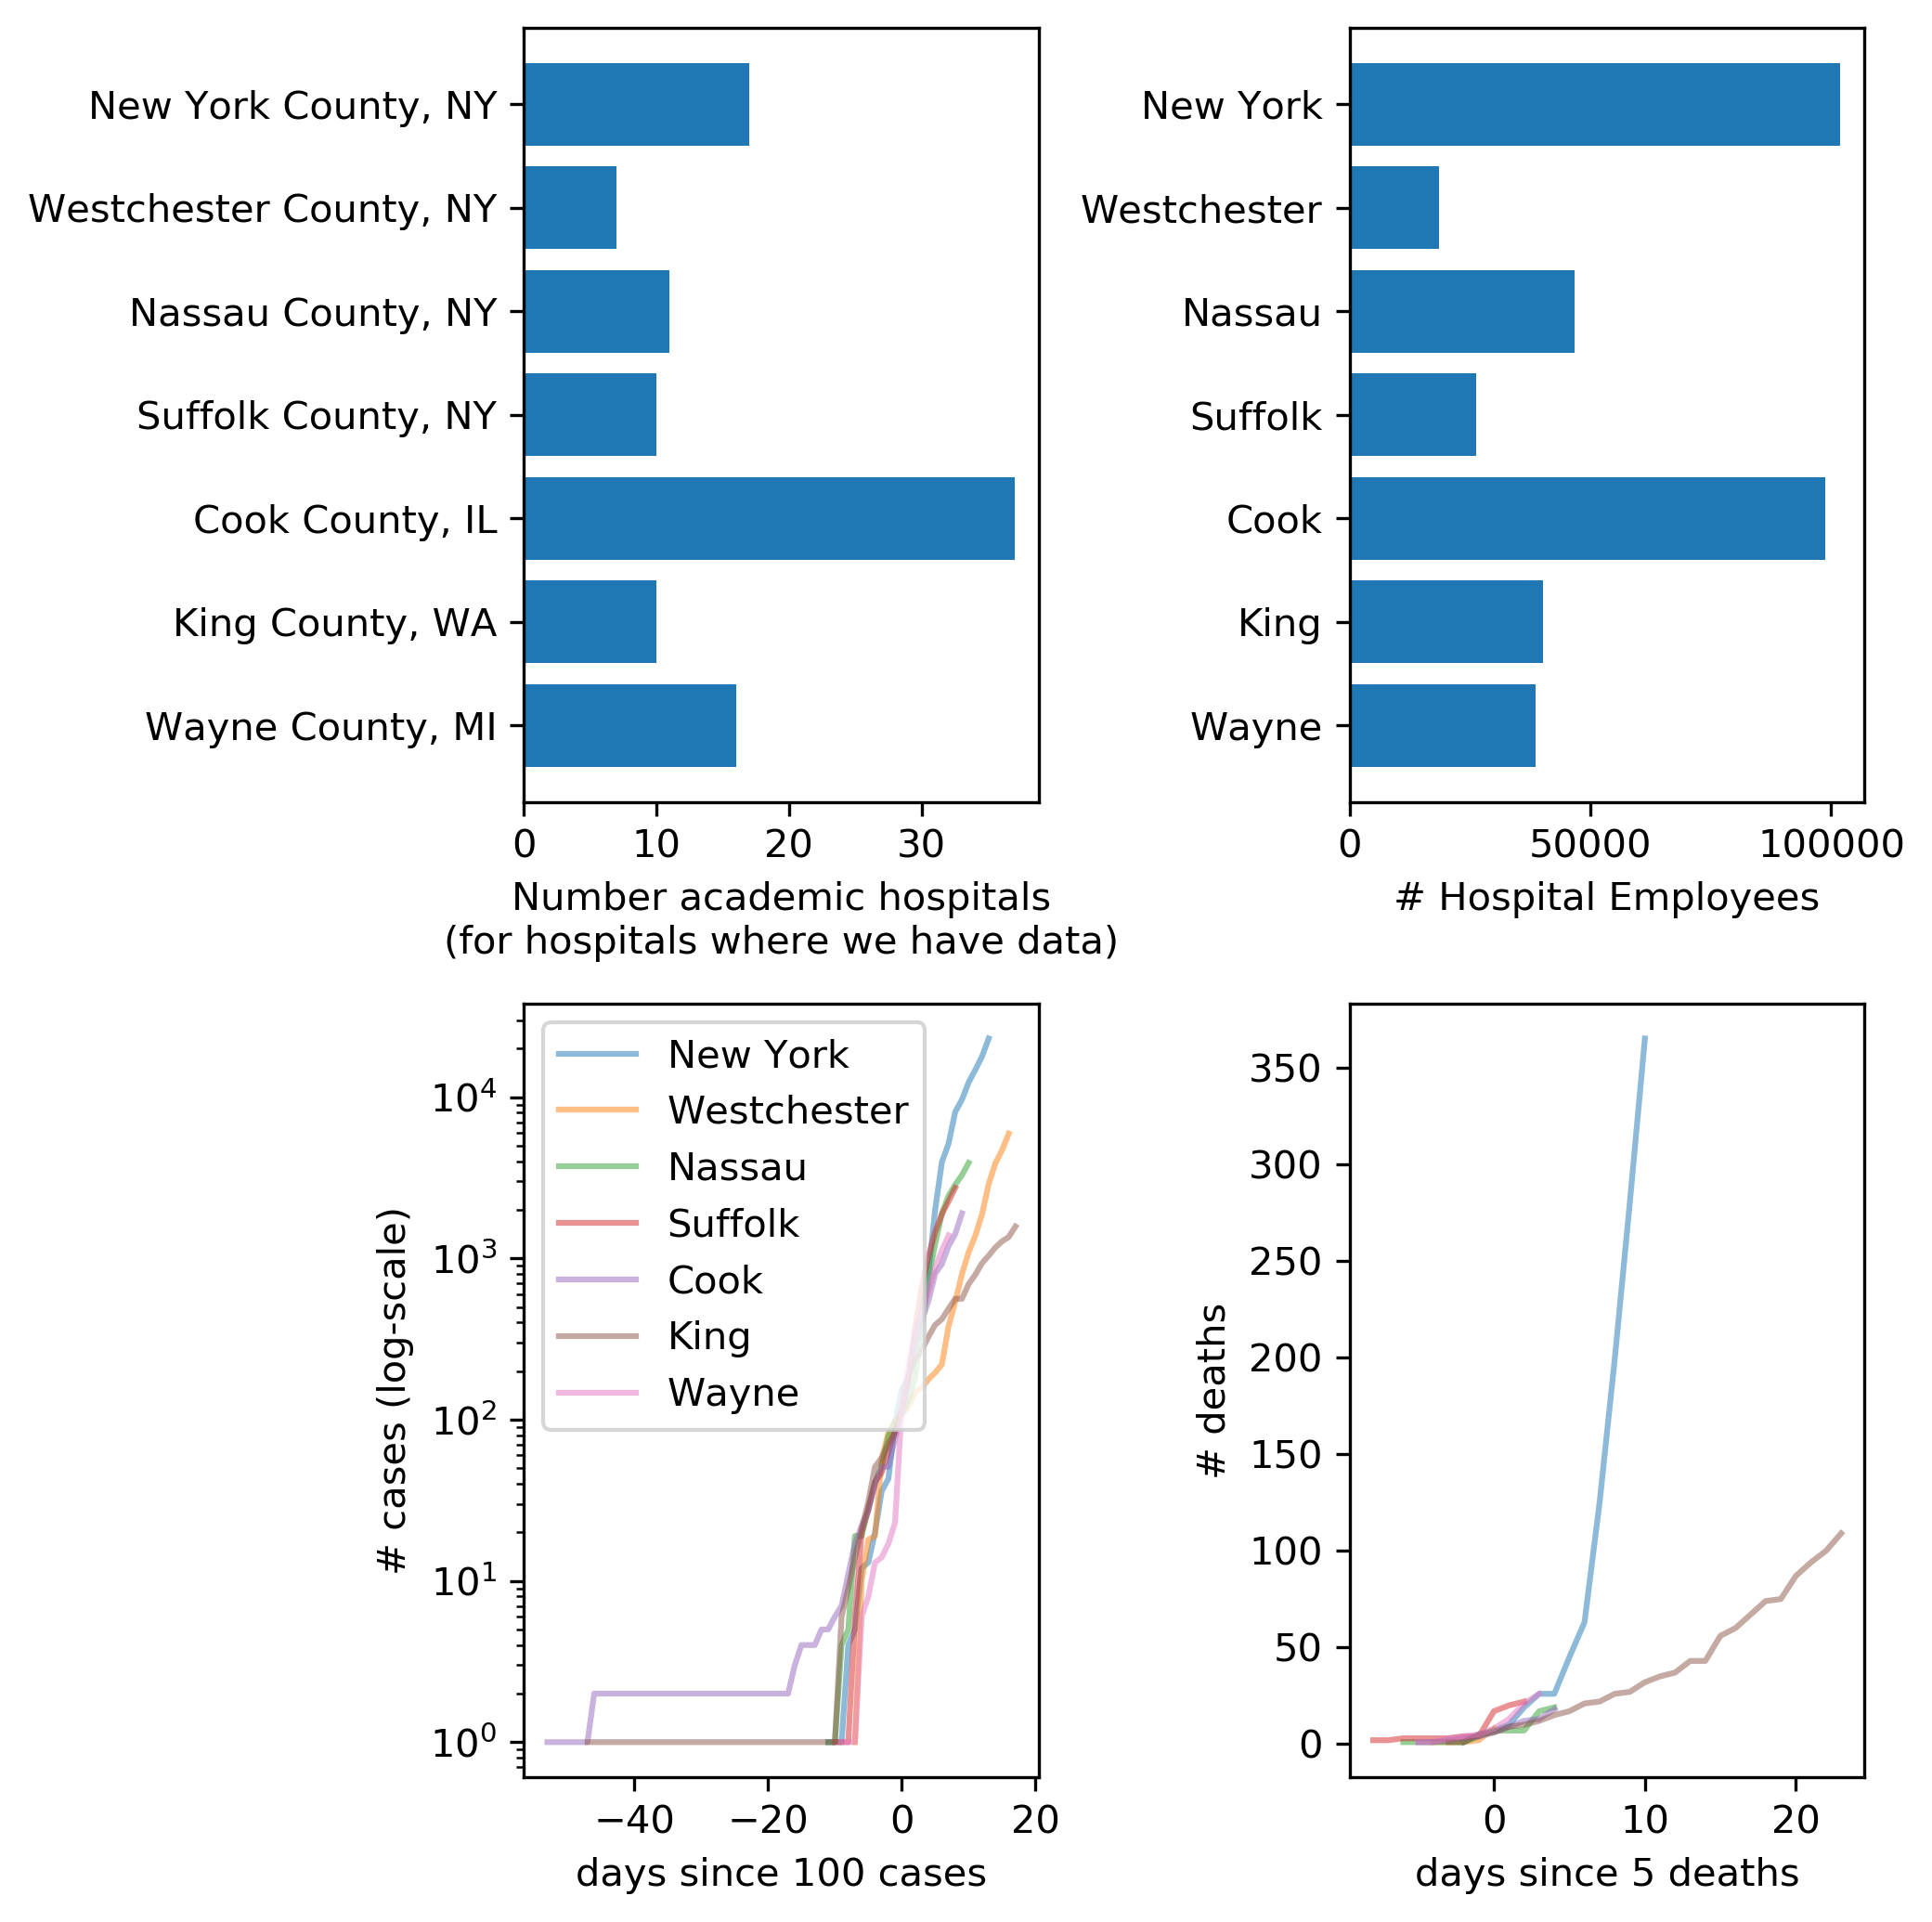

In [7]:
R, C = 2, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 7))


plt.subplot(R, C, 1)
c = 'County Name'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
# d = df[outcome_keys + hospital_keys]
# d = d.sort_values('New Deaths', ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals\n(for hospitals where we have data)')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['Hospital Employees in County'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('# Hospital Employees')

r = df_county
for i in range(NUM_COUNTIES):
    row = df_county.iloc[i]
    deaths = np.array([x for x in row['deaths'] if x > 0])
    cases = np.array([x for x in row['cases'] if x > 0])
    
    CASES_ALIGNMENT = 100
    idx_align = np.where(cases > CASES_ALIGNMENT)[0][0]
    n = cases.size
    
    DEATHS_ALIGNMENT = 5
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size

    
    plt.subplot(R, C, 3)
    plt.plot(np.arange(n) - idx_align, cases, alpha=0.5, label=row['CountyName'])
    plt.yscale('log')
    plt.ylabel('# cases (log-scale)')
    plt.xlabel(f'days since {CASES_ALIGNMENT} cases')
    plt.legend()
    
    plt.subplot(R, C, 4)
    plt.plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5)
    plt.ylabel('# deaths')
    plt.xlabel(f'days since {DEATHS_ALIGNMENT} deaths')
plt.tight_layout()
plt.show()

# intra-county plots

/Users/Tiffany/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  # This is added back by InteractiveShellApp.init_path()


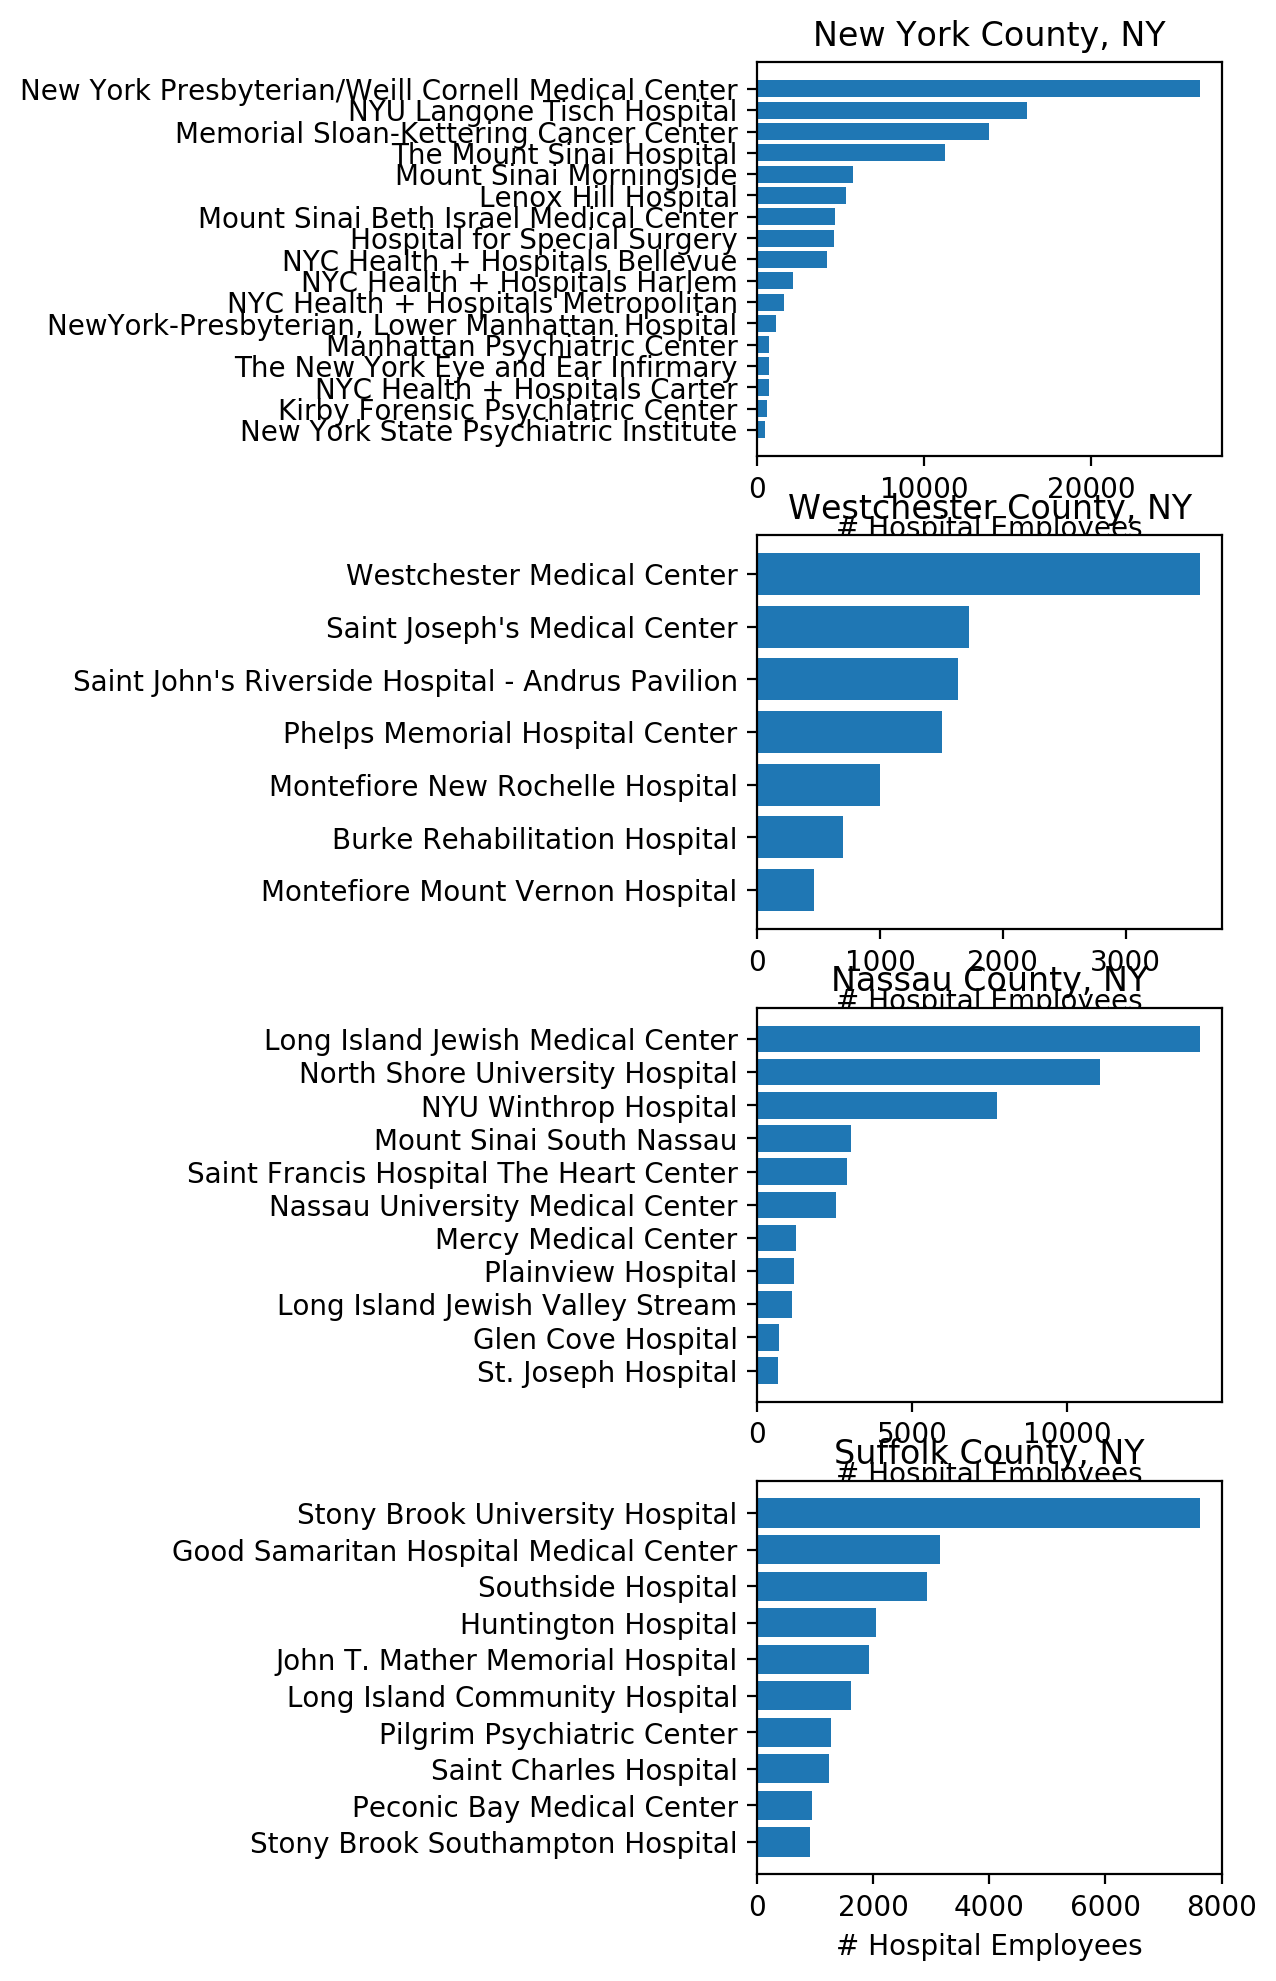

In [9]:
county_names = d[c].unique()[:NUM_COUNTIES]
R, C = 4, 1
plt.figure(figsize=(C * 3, R * 3), dpi=200)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    cn = county_names[i]
    dc = d[d[c] == cn]
    plt.barh(dc['Facility Name'][::-1], dc['Hospital Employees'][::-1])
    plt.title(cn)
    plt.xlabel('# Hospital Employees')
plt.tight_layout()
# plt.subplots_adjust(bottom=1)
plt.show()